# Formula 1 Driver Stats
The goal of this project is to efficiently analyze data from a SQL database containing five related tables: <i>results, races, drivers, constructors,</i> and <i>circuits.</i>

![ERdiag](er_diagram2.png)

I want to be able to run SQL queries against the database and quickly view the results in either tabular or visual formats--all within this python environment. The workflow will go like this:
<ol>
<li><b>SQLAlchemy</b> will access the database and run our MySQL queries.</li>
<li><b>Pandas</b> will house the results of the query within a dataframe for easy viewing of tabular data.</li>
<li><b>Plotly Express</b> will build interactive plots for our analysis. 
<ul><li><i>Note: For the purposes of making these plots visible on GitHub, I will be saving them in a static png format.</i></li></ul>
</ol>

## Project Setup and Imports

In [1]:
# library imports 
import sqlalchemy
import pandas as pd
import plotly.express as px

# database setup
engine = sqlalchemy.create_engine('mysql+pymysql://root:pw@localhost:3306/formula1')

## Analysis

### Top 20 Drivers by Total Wins

In [3]:
query = '''
SELECT
    CONCAT(dr.forename, ' ', dr.surname) AS name
    , COUNT(re.positionOrder) AS wins
FROM results re
INNER JOIN drivers dr ON dr.driverId = re.driverId
WHERE re.positionOrder = 1
GROUP BY re.driverId
ORDER BY wins DESC
;
'''


wins_by_driver = pd.read_sql_query(query, engine)

In [18]:
wins_by_driver[:20]

,name,wins
0,Lewis Hamilton,103
1,Michael Schumacher,91
2,Sebastian Vettel,53
3,Alain Prost,51
4,Ayrton Senna,41
5,Fernando Alonso,32
6,Nigel Mansell,31
7,Jackie Stewart,27
8,Niki Lauda,25
9,Jim Clark,25


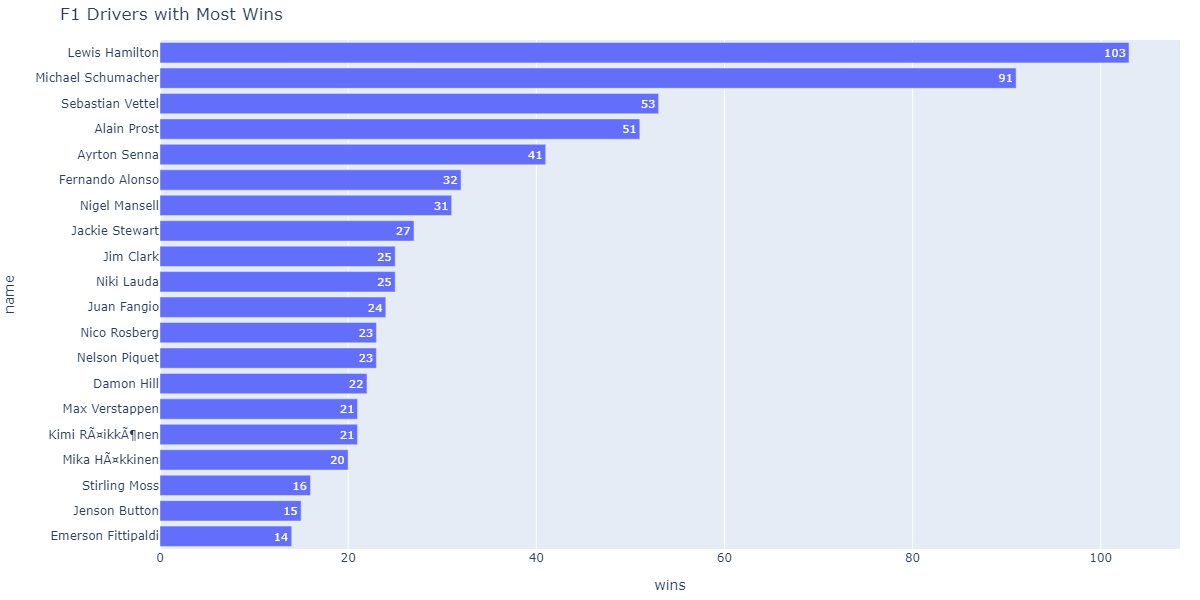

In [5]:
fig = px.bar(wins_by_driver[:20], x='wins', y='name',text='wins', title='F1 Drivers with Most Wins',
    width=1200, height=600)
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    margin=dict(l=10, r=20, t=40, b=10))
    
## fig.show() <-- use for interactive plots, not visible on github
fig.show("png")

### Total Wins per Driver for each Constructor

In [6]:
query = '''
SELECT
    CONCAT(dr.forename, ' ', dr.surname) AS driver_name
    , c.name AS constructor_name
    , COUNT(re.positionOrder) AS wins
FROM results re
INNER JOIN drivers dr ON re.driverId = dr.driverId
INNER JOIN constructors c ON re.constructorId = c.constructorId
WHERE re.positionOrder = 1
GROUP BY driver_name, constructor_name
ORDER BY wins desc
;
'''
wins_by_driver_constructor = pd.read_sql_query(query, engine)

In [7]:
wins_by_driver_constructor.head(3)

,driver_name,constructor_name,wins
0,Lewis Hamilton,Mercedes,82
1,Michael Schumacher,Ferrari,72
2,Sebastian Vettel,Red Bull,38


In [14]:
fig = px.bar(wins_by_driver_constructor, x='wins', y='driver_name', text='wins', color='constructor_name', 
    title='Wins per Constructor by Driver', width=1200, height=800)

fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    margin=dict(l=10, r=20, t=40, b=10))

fig.update_traces(width=0.8)

fig.update_yaxes(range=(wins_by_driver_constructor.driver_name.nunique()-20.5, wins_by_driver_constructor.driver_name.nunique()-0.5))

## fig.show() <-- use for interactive plots, not visible on github
fig.show()

### Each Current Driver's First F1 Win

In [9]:
query = '''
SELECT 
	driver_name 
	, CASE WHEN race IS NULL THEN "Seeking First Win" ELSE race END AS first_win
FROM (
	SELECT DISTINCT CONCAT(dr.forename, ' ', dr.surname) as driver_name 
	FROM results re
	LEFT JOIN races ra ON ra.raceId = re.raceId
	LEFT JOIN drivers dr ON dr.driverId = re.driverId
	WHERE ra.year = 2022) AS current_drivers
LEFT JOIN (
	SELECT 
		CONCAT(dr.forename, ' ', dr.surname) AS driver
		, MIN(concat(ra.year, ' ', ra.name)) AS race
		, MIN(concat(ra.year, ra.round)) AS round
	FROM results re
	LEFT JOIN races ra ON ra.raceId = re.raceId
	LEFT JOIN drivers dr ON dr.driverId = re.driverId
	where re.positionOrder = 1
	GROUP BY re.driverId) AS first_wins ON first_wins.driver = current_drivers.driver_name
ORDER BY CASE WHEN round IS NULL THEN 99999 ELSE round END ASC, driver_name ASC;'''

drivers_first_win = pd.read_sql_query(query, engine)

In [10]:
drivers_first_win

,driver_name,first_win
0,Fernando Alonso,2003 Hungarian Grand Prix
1,Lewis Hamilton,2007 Canadian Grand Prix
2,Sebastian Vettel,2008 Italian Grand Prix
3,Daniel Ricciardo,2014 Belgian Grand Prix
4,Max Verstappen,2016 Spanish Grand Prix
5,Valtteri Bottas,2017 Abu Dhabi Grand Prix
6,Charles Leclerc,2019 Belgian Grand Prix
7,Sergio PÃ©rez,2020 Sakhir Grand Prix
8,Pierre Gasly,2020 Italian Grand Prix
9,Esteban Ocon,2021 Hungarian Grand Prix


### Driver Stats Lookup

This section stil WIP.

In [11]:
query = '''
SELECT 
    dr.driverId,
    CONCAT(dr.forename, ' ', dr.surname) AS driver,
    CASE WHEN driver_constructor.current_constructor IS NULL THEN "Non-active Driver" ELSE driver_constructor.current_constructor END AS current_constructor,
    GROUP_CONCAT(DISTINCT co.name SEPARATOR', ') as all_constructors,
    COUNT(re.raceId) AS total_career_races,
    COUNT(CASE WHEN re.positionOrder = 1 THEN 1 END) AS total_career_wins,
    COUNT(CASE WHEN re.positionOrder <= 3 THEN 1 END) AS total_career_podiums,
    COUNT(CASE WHEN re.positionOrder <= 10 THEN 1 END) AS total_career_top10s
FROM results re
INNER JOIN drivers dr ON dr.driverId = re.driverId
INNER JOIN constructors co ON co.constructorId = re.constructorId
LEFT JOIN (
	SELECT 
		dr1.driverId as id, 
		co1.name as current_constructor
	FROM results re1
	INNER JOIN drivers dr1 on dr1.driverId = re1.driverId
	INNER JOIN constructors co1 on co1.constructorId = re1.constructorId
	INNER JOIN races ra1 on ra1.raceId = re1.raceId
	WHERE ra1.year = 2022
	GROUP BY dr1.driverId
    ) as driver_constructor 
ON driver_constructor.id = dr.driverId
GROUP BY dr.driverId
ORDER BY 
	CASE WHEN current_constructor IS NULL 
    THEN 'zzzzz' ELSE driver END asc
;
'''

driver_stats = pd.read_sql_query(query, engine)

In [12]:
driver_stats

,driverId,driver,current_constructor,all_constructors,total_career_races,total_career_wins,total_career_podiums,total_career_top10s
0,848,Alexander Albon,Williams,"Red Bull, Toro Rosso, Williams",41,0,2,26
1,832,Carlos Sainz,Ferrari,"Ferrari, McLaren, Renault, Toro Rosso",144,0,8,87
2,844,Charles Leclerc,Ferrari,"Ferrari, Sauber",84,4,16,59
3,817,Daniel Ricciardo,McLaren,"HRT, McLaren, Red Bull, Renault, Toro Rosso",213,8,32,125
4,839,Esteban Ocon,Alpine F1 Team,"Alpine F1 Team, Force India, Manor Marussia, R...",92,1,2,55
...,...,...,...,...,...,...,...,...
849,851,Jack Aitken,No Longer Racing,Williams,1,0,0,0
850,19,Anthony Davidson,No Longer Racing,"BAR, Minardi, Super Aguri",24,0,0,0
851,853,Nikita Mazepin,No Longer Racing,Haas F1 Team,22,0,0,0
852,21,Giancarlo Fisichella,No Longer Racing,"Benetton, Ferrari, Force India, Jordan, Minard...",231,3,19,116


In [13]:
driver_name = input("Enter a driver name: ") ## alonso
driver_stats[driver_stats['driver'].str.contains(driver_name, regex=True, case=False)]


,driverId,driver,current_constructor,all_constructors,total_career_races,total_career_wins,total_career_podiums,total_career_top10s
5,4,Fernando Alonso,Alpine F1 Team,"Alpine F1 Team, Ferrari, McLaren, Minardi, Ren...",339,32,98,225
